# Setup Variables

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
# DATASET = 'MNIST'
# POSTFIX = 'SGD-32-30'
DATASET = 'GTSRB'
POSTFIX = 'AdamW-32-30'
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'
SEED = 42
CUDA = 0
LHL = int(POSTFIX.split('-')[-1])
GPU_NAME = f'cuda:{CUDA}'

In [2]:
# TEST_DATASET = 'FashionMNIST'
TEST_DATASET = 'Cifar10'

In [3]:
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [4]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from fastprogress import progress_bar

from utilities.utils import *
from utilities.pathManager import fetchPaths
from utilities.MonitorUnifiedBDD import MonitorBDD

# Paths

In [6]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_scaler_pca']

# data folder for test dataset
test_path_data = path_data.parent / TEST_DATASET

# load config file
configs = load_json(paths['configuration'])
config = configs['configuration']

# model config
model_setup = configs['model_setup']
model_config = configs['model_config']

# saved model
path_model = next(paths['saved_models'].glob('*.pth.tar'))

path_model

PosixPath('/home/ah19/runtime-monitoring/experiments/GTSRB/saved-models/GTSRB_AdamW-32-30/GTSRB_AdamW-32-30-acc-0.958-loss-0.15.pth.tar')

# Get LHL Data for the Test Dataset

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn

In [8]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN
from models.cifar10_dla import Cifar10_DLA
from models.cifar10_model import Cifar10_CNN

from models.transformers import transformers

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN,
#     'cifar10': Cifar10_DLA,
    'cifar10': Cifar10_CNN
}

model_ = models[DATASET.lower()]
transformer = transformers[DATASET.lower()]

In [9]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

In [10]:
feature_names_test = get_labels(TEST_DATASET)

# train_data = get_dataset(TEST_DATASET, test_path_data, train=True, transform=transformer['train'])
test_data = get_dataset(TEST_DATASET, test_path_data, train=False)

Files already downloaded and verified


In [11]:
_, test_sample = train_test_split(
    torch.range(0, len(test_data.targets)-1, dtype=torch.int32),
    test_size=1000, shuffle=True, stratify=test_data.targets
)

testloader = get_dataLoader(test_data, model_config['batch_size'], False)

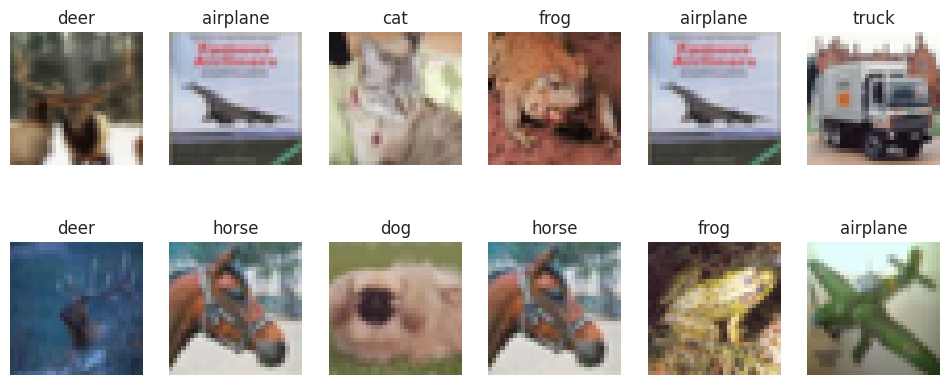

In [12]:
show_images_loader(testloader, feature_names=feature_names_test)

In [13]:
# torch 2.0 compile and parallel data training
model_setup['last_hidden_neurons'] = LHL
model = model_(**model_setup).to(device)
model = torch.compile(model)

# load model weights
model.load_state_dict(torch.load(path_model)['model'])

# eavluation mode
model.eval()

''

''

In [14]:
mean_, std_ = transformer['test'].transforms[1].mean, transformer['test'].transforms[1].std
mean_, std_

((0.3381, 0.3101, 0.3194), (0.1625, 0.1625, 0.1721))

In [15]:
x = transformer['test'].transforms[1](torch.stack([test_data[i][0] for i in test_sample]))

In [16]:
logits, _ = model.output_last_layer(x.to(device))
logits = logits.cpu().numpy()
logits = pd.DataFrame(logits, columns=[f'x{i}' for i in range(logits.shape[1])])
logits.shape

(1000, 30)

In [17]:
# res = torch.zeros((len(testloader), model_config['batch_size'], LHL))

In [18]:
# for i, (x, _) in enumerate(trainloader):
#     x = x.to(device)
#     logits, _ = model.output_last_layer(x)
#     res[i] = logits

In [19]:
# (res.reshape([len(train_data), LHL])[:model_config['batch_size']] == res[0]).all()

In [20]:
# inference_df = pd.DataFrame(res.reshape([len(train_data), LHL]), columns=[f'x_{i}' for i in range(LHL)])

In [21]:
# num_samples = 20

# viz_sample = inference_df.sample(num_samples)
# x = np.repeat(np.arange(LHL, dtype=np.int8), num_samples) + 1

# Seed

In [22]:
np.random.seed(SEED)

# Import Data

In [23]:
# import Data
df_train = pd.read_csv(path_lhl_raw / f"{FILENAME_POSTFIX}_raw_train.csv")

# select only true classified
df_true = df_train[df_train["true"] == True].copy()
df_true = df_true.drop("true", axis=1).reset_index(drop=True)

df_test = pd.read_csv(path_lhl_raw / f"{FILENAME_POSTFIX}_raw_test.csv")

print(f"Train accuracy: {(df_train['true'].sum() / df_train.shape[0] * 100).round(2)}%")
print(f"Test accuracy: {(df_test['true'].sum() / df_test.shape[0] * 100).round(2)}%")

Train accuracy: 96.9%
Test accuracy: 95.78%


In [24]:
gte_mean = load_json(path_lhl / 'neurons_scaler_pca_gte_mean.json')
top_third = load_json(path_lhl / 'neurons_scaler_pca_top_third.json')

In [32]:
# each set of data has its own threshold
thld_p = 0.5
eta = 3
# neurons = []
neurons = gte_mean
# neurons = top_third

# calculate threshold
# thld = np.quantile( df_true.drop('y', axis=1), thld_p, axis=0)
thld = np.mean( df_true.drop('y', axis=1), axis=0)
# thld = np.zeros( df_true.drop('y', axis=1).shape[0], axis=0)

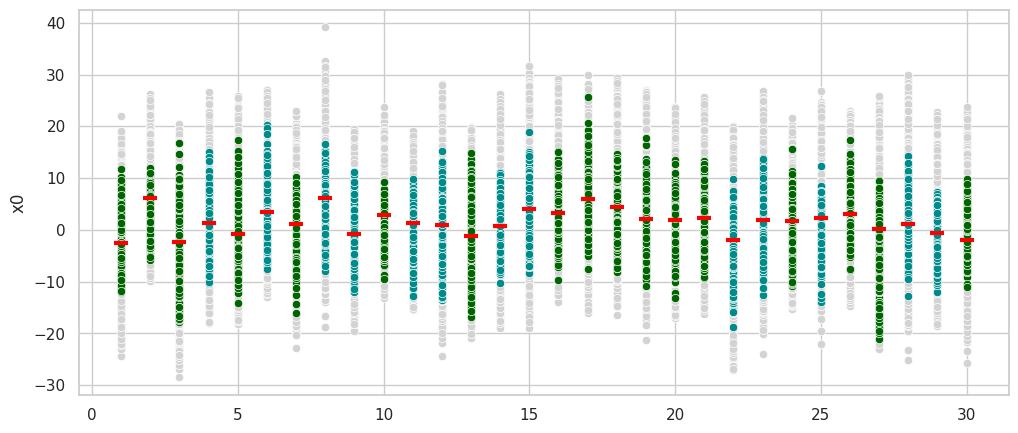

In [33]:
for i, c in enumerate(df_true.drop('y', axis=1).columns):
    sns.scatterplot( x=i+1,  y=df_true[c], c='lightgray')

for i, c in enumerate(logits.columns):
    sns.scatterplot( x=i+1,  y=logits[c], c='darkgreen' if c in neurons else 'darkcyan')
    
sns.scatterplot(
    x=[*range(1, df_true.shape[1])],
    y=thld,
    marker='_', s=100, c='red', linewidth=3

)

plt.show()

# Build BDD

In [34]:
# target data
df_logits_copy = logits.copy()
df_logits_copy['y'] = 1
df_logits_copy['true'] = 1

# BDD
patterns = MonitorBDD( df_true.shape[1]-1, thld, neurons=neurons)
df_train_copy, df_test_copy, df_logits_copy = patterns.add_dataframe( df_true, eta, eval_dfs=[df_train.copy(), df_test.copy(), df_logits_copy] )

    
# score
df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)
df_logits_scores = patterns.score_dataframe_multi_eta(df_logits_copy, eta)

    
# add metadata
patterns.stats['thld'] = f'qth_{thld_p}'

In [35]:
patterns.stats

,thld,eta,build_time_min,size_mb,reorder_time_min,num_patterns,num_unique_patterns_%,num_reorder,num_neurons,start_time,end_time
1,qth_0.5,0.0,0.7,4304.515,0.0,61985.0,17.500,0.0,17.0,2023-07-28 21:34:03,2023-07-28 21:34:03
2,qth_0.5,1.0,3.9,4306.643,0.0,102191.0,0.456,0.0,17.0,2023-07-28 21:34:05,2023-07-28 21:34:07
3,qth_0.5,2.0,1.7,4306.643,0.0,52656.0,0.276,0.0,17.0,2023-07-28 21:34:08,2023-07-28 21:34:09
4,qth_0.5,3.0,0.8,4306.676,0.0,27032.0,0.226,0.0,17.0,2023-07-28 21:34:10,2023-07-28 21:34:11


In [36]:
df_train_scores

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
0,0,1538.0,4.0,4.0,0.0,0.002601,1.000000,0.000000,0
1,1,1483.0,44.0,44.0,0.0,0.029670,1.000000,0.000000,0
2,2,1473.0,30.0,30.0,0.0,0.020367,1.000000,0.000000,0
3,3,1478.0,35.0,35.0,0.0,0.023681,1.000000,0.000000,0
4,4,1528.0,47.0,47.0,0.0,0.030759,1.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...
175,40,1489.0,3.0,3.0,0.0,0.002015,1.000000,0.000000,3
176,41,1461.0,2.0,2.0,0.0,0.001369,1.000000,0.000000,3
177,42,1432.0,4.0,4.0,0.0,0.002793,1.000000,0.000000,3
178,all,63968.0,107.0,107.0,0.0,0.001673,1.000000,0.000000,3


In [37]:
df_test_scores

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
0,0,94.0,6.0,2.0,4.00,0.063830,0.333333,0.666667,0
1,1,107.0,12.0,0.0,12.00,0.112150,1.000000,0.000000,0
2,2,97.0,7.0,0.0,7.00,0.072165,1.000000,0.000000,0
3,3,100.0,15.0,1.0,14.00,0.150000,0.066667,0.933333,0
4,4,107.0,12.0,5.0,7.00,0.112150,0.416667,0.583333,0
...,...,...,...,...,...,...,...,...,...
175,40,95.0,4.0,1.0,3.00,0.042105,0.250000,0.750000,3
176,41,99.0,7.0,0.0,7.00,0.070707,1.000000,0.000000,3
177,42,89.0,0.0,0.0,0.00,0.000000,0.000000,1.000000,3
178,all,4192.0,67.0,18.0,49.00,0.015983,0.268657,0.731343,3


In [38]:
df_logits_scores

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
0,1,1000.0,512.0,0.0,512.0,0.512,1.000,0.0,0
1,all,1000.0,512.0,0.0,512.0,0.512,1.000,0.0,0
2,all_mean,1000.0,512.0,0.0,0.0,0.000,0.512,0.0,0
3,1,1000.0,117.0,0.0,117.0,0.117,1.000,0.0,1
4,all,1000.0,117.0,0.0,117.0,0.117,1.000,0.0,1
5,all_mean,1000.0,117.0,0.0,0.0,0.000,0.117,0.0,1
6,1,1000.0,84.0,0.0,84.0,0.084,1.000,0.0,2
7,all,1000.0,84.0,0.0,84.0,0.084,1.000,0.0,2
8,all_mean,1000.0,84.0,0.0,0.0,0.000,0.084,0.0,2
9,1,1000.0,75.0,0.0,75.0,0.075,1.000,0.0,3
